In [1]:
# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
import pydrake
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydrake.all import (VectorSystem, DiagramBuilder, SymbolicVectorSystem, LogVectorOutput,MathematicalProgram,
                         Variable, Simulator, cos, sin,tan,sqrt, ToLatex, Variable, Variables, Polynomial, Solve)
from math import pi          
import math               

In [3]:

# state of the robot (in cartesian coordinates)
x = Variable("x")          # 
y = Variable("y")          #  
theta = Variable("theta")  # vehicle orienttaion
 
cartesian_state = [x, y, theta]

# control input of the robot
v = Variable("v")             # driving velocity input
phi = Variable("phi")         # steering velocity input
input = [v, phi]
L = 0.8
# nonlinear dynamics, the whole state is measured (output = state)
dynamics = [v * cos(theta), 
            v * sin(theta), 
           (v * tan(phi))/L]

robot = SymbolicVectorSystem(
    state=cartesian_state,
    input=input,
    output=cartesian_state,
    dynamics=dynamics,
)

def clip(val, min_, max_):
    return min_ if val < min_ else max_ if val > max_ else val

In [4]:
class ParkingController(VectorSystem):

    def __init__(self, start = [0.0]):
        # 4 inputs (robot state)
        # 2 outputs (robot inputs)
        VectorSystem.__init__(self, 3, 2)
        self.start_x_y = start

    def euc(self, x, y, x_obs, y_obs):
      # x and y are vehicle pose
      return math.sqrt((x-x_obs)**2) + ((y-y_obs)**2)

    def DoCalcVectorOutput(
            self,
            context,          # not used
            cartesian_state,  # input of the controller
            controller_state, # not used
            input             # output of the controller
        ):
      
        # upack state of the robot
        x_c, y_c, theta_c = cartesian_state
        
        # set the target states
        x_t, y_t  = 19,-16

        theta_r = math.atan2((y_c-self.start_x_y[1]), (x_c-self.start_x_y[0]))

        if (x_c == 0.0 and y_c == 0):
            print(theta_r)

        # pack the errors
        
        T = np.array([[-np.cos(theta_r)  , -np.sin(theta_r) ,0],    
                      [ np.sin(theta_r)  , -np.cos(theta_r) ,0], 
                      [ 0                ,  0               ,1]])

        e = np.array([x_c-x_t, y_c-y_t, theta_c-theta_r])
        te_dynamics = T.dot(e)
        
        v_r = 1.5
 
        A = np.matrix([[0, -v_r], [0, 0]])    
        B = np.matrix([0, -v_r/L]).transpose()
        q1 = 1
        q2 = 10
        r = 1
        Q = np.matrix([[q1, 0], [0, q2]])    
        R = np.matrix([r])    

        K, X, eigVals = lqr(A, B, Q, R)
        
        s = math.sqrt((x_c-x_t)**2+(y_c-y_t)**2)
        #print(s)
        if s <= 0.1:
            v_r = 0.0
        
        optimal_phi = clip(K.dot(te_dynamics[1:3]),-0.6,0.6)
        
        # evaluate the function below and return the robot's input
        input[:] = [v_r, optimal_phi]
 

In [5]:
import scipy.linalg
 
def lqr(A,B,Q,R):
  """Solve the continuous time lqr controller.
  
  dx/dt = A x + B u
  
  cost = integral x.T*Q*x + u.T*R*u
  """
  #ref Bertsekas, p.151
  
  #first, try to solve the ricatti equation
  X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
  
  #compute the LQR gain
  K = np.matrix(scipy.linalg.inv(R)*(B.T*X))
  
  eigVals, eigVecs = scipy.linalg.eig(A-B*K)
  
  return K, X, eigVals


In [6]:
builder = DiagramBuilder()

# add the robot to the diagram
# the method .AddSystem() simply returns a pointer to the system
# we passed as input, so it's ok to give it the same name
robot = builder.AddSystem(robot)

# add the controller
controller = builder.AddSystem(ParkingController(start=[0,0]))

# wire the controller with the system
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

# add a logger to the diagram
# this will store the state trajectory
logger = LogVectorOutput(robot.get_output_port(0), builder)

# complete the construction of the diagram
diagram = builder.Build()
# set up a simulation environment
simulator = Simulator(diagram)

# set the initial cartesian state to a random initial position
# try initial_state = np.random.randn(3) for a random initial state
initial_state = [0,0,0] 
context = simulator.get_mutable_context()
context.SetContinuousState(initial_state)

# simulate from zero to sim_time
# the trajectory will be stored in the logger
integrator = simulator.get_mutable_integrator()
target_accuracy = 1E-1
integrator.set_target_accuracy(target_accuracy)

maximum_step_size = 0.2
integrator.set_maximum_step_size(maximum_step_size)

minimum_step_size = 2E-5
integrator.set_requested_minimum_step_size(minimum_step_size)

integrator.set_throw_on_minimum_step_size_violation(True)
 
integrator.set_fixed_step_mode(True)

sim_time = 20.0
simulator.AdvanceTo(sim_time)

/tmp/ipykernel_62934/1332464938.py:58: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  input[:] = [v_r, optimal_phi]


In [7]:
# vehicle size in the plot
length = .6
width = .3

# function that draws a triangle given the cartesian state of the robot
def draw_robot(cartesian_state, **kwargs):
    
    # transformation matrix from global to robot frame
    z1, z2, z3 = cartesian_state
    T = np.array([
        [np.cos(z3), -np.sin(z3), z1],
        [np.sin(z3), np.cos(z3), z2]
    ])

    # compute cartesian coordinates of the corners of the car
    left_back = T.dot([-length/2, width/2, 1])
    right_back = T.dot([-length/2, -width/2, 1])
    left_front = T.dot([length/2, width/2,  1])
    right_front = T.dot([length/2, -width/2,  1])

    heading_arrow_tail = T.dot([length/2,0,1])
    heading_arrow_head = T.dot([length,0,1])
    
    # draw a triangle that symbolizes the robot
    robot = patches.Polygon(
        np.vstack([heading_arrow_head, heading_arrow_tail, left_front, left_back, right_back, right_front, heading_arrow_tail]),
        facecolor='none',
        **kwargs
    )

    obstacle = patches.Ellipse((5,5),1.0,1.0)
 
    plt.gca().add_patch(robot)
    #plt.gca().add_patch(obstacle)


# function that draws the trajectory of the robot
# initial and final states are red and blue, respectively
def draw_trajectory(trajectory):

    # draw trajectory of the robot in black
    for state in trajectory.T:
        draw_robot(state, edgecolor='k')
        
    # draw initial configuration of the robot in red
    draw_robot(
        trajectory[:,0],
        edgecolor='r',
        linewidth=3,
        label='Initial configuration'
    )

    # draw final configuration of the robot in blue
    draw_robot(
        trajectory[:,-1],
        edgecolor='b',
        linewidth=3,
        label='Final configuration'
    )

Text(0.5, 1.0, 'Robot parking trajectory')

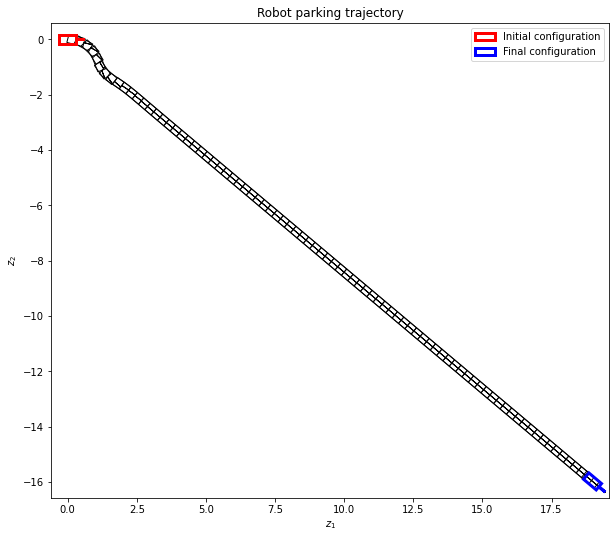

In [8]:
log = logger.FindLog(context)

# draw parking trajectory
plt.figure(figsize=(10, 10))
draw_trajectory(log.data()[0:3])

# adapt figure limits to the trajectory
robot_size = max(length, width)
plt.xlim([
        min(log.data()[0,:]) - robot_size,
        max(log.data()[0,:]) + robot_size
])
plt.ylim([
        min(log.data()[1,:]) - robot_size,
        max(log.data()[1,:]) + robot_size
])

# misc plot settings
plt.gca().set_aspect('equal')
plt.legend()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Robot parking trajectory')